# Introduction

After completing the Python, Pandas, Intro to Machine Learning and Intermediate Machine Learning courses on Kaggle, I decided to apply these skills to a dataset.

The data I am using is from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course/overview). In the dataset, we are provided with 79 columns describing various features of properties. The train data also includes Sales Price, the target we will try to predict for the test data.

#### Steps taken

1. Data Exploration
2. Handling missing data
3. Preprocessing of categorical data
4. Basic feature engineering
5. Testing for category discrepancies between the train and test data
6. Creating a pipeline
7. Model tuning
8. Generating predictions

#### Results

My best score upon submitting my test data predictions to kaggle was a RMSE of 13851, which is in the top 2% for this competition.

In [3]:
# Import required tools and libraries 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
import warnings

In [4]:
# Load train and test data

train_data = pd.read_csv('Data/train.csv')

test_data = pd.read_csv('Data/test.csv')

## Separate target from predictors

In [5]:
# Remove any rows in the train data without sale price information as this is the target
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Creating X (predictors) and y (target)
y = train_data.SalePrice
train_data.drop(['SalePrice'], axis=1, inplace=True)
X_train = train_data.copy()

In [6]:
# Suppress warnings regarding XGBoost and memory usage
warnings.filterwarnings(action='ignore', category=UserWarning)

# Data exploration

In [7]:
# Have a look at the structure of the data and columns within it
print(X_train.shape)

print(X_train.columns)

X_train.describe()

(1460, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [8]:
# Select columns with numerical data
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]

# Select columns with categorical data
object_cols = [col for col in train_data.columns if train_data[col].dtype == "object"]

print("Number of numerical columns: ", len(numeric_cols))
print("Number of categorical columns: ", len(object_cols))

Number of numerical columns:  37
Number of categorical columns:  43


The data columns in the dataset can be split into the following categories:

**Numerical**
- Columns with no missing data in both the training and test data - no actions required
- Columns with missing data - either data will need to be imputed or the column should be dropped  
    
    

**Categorical**  

*Because we will be using a Regressor model, all columns will ultimately need to be in a numerical format*
- Columns with missing data - either data will need to be imputed or the column should be dropped
- Columns with no missing data or where missing data has been imputed - use ordinal encoding or one-hot encoding

# Testing RMSE function

The funtion below uses cross_val_score() to calculate root mean squared error (RMSE), averaged across five different folds. This function will be used to determine the best approach for processing data by indicating which approach results in the lowest RMSE.  

We are using RMSE as this is the scoring metric used for this kaggle competition.

In [9]:
# Define function

def RMSE_score(X):
    model_1 = XGBRegressor(random_state=0)

    scores = -1 * cross_val_score(model_1, X, y,
                                  cv=5,
                                  scoring='neg_root_mean_squared_error')

    print("Average RMSE score:", scores.mean())

In [10]:
# Select numeric columns only as have not yet done any preprocessing
X_numeric = train_data[numeric_cols].copy()

# Measure 'base' RMSE
RMSE_score(X_numeric)

Average RMSE score: 30306.791836659908


# Missing Data

Both the train and test data will be examined for missing data to ensure even if columns only have missing data in the test data, this has been taken into consideration.

## Numerical missing data

In [11]:
# Get numerical columns with missing data from the train dataset

missing_data_count_by_column = X_numeric[numeric_cols].isnull().sum()
print(missing_data_count_by_column[missing_data_count_by_column > 0].sort_values(ascending=False))

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64


Let's check if there is missing data in the test data, and if there is, that it is from the same columns as the train data:

In [12]:
# Get numerical columns with missing data from the test dataset

missing_testdata_count_by_column = test_data[numeric_cols].isnull().sum()
print(missing_testdata_count_by_column[missing_testdata_count_by_column > 0].sort_values(ascending=False))

LotFrontage     227
GarageYrBlt      78
MasVnrArea       15
BsmtFullBath      2
BsmtHalfBath      2
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
GarageArea        1
dtype: int64


The first three columns (which have the most missing data) are also missing in the training data. The other columns are missing one or two values each:
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- TotalBsmtSF: Total square feet of basement area
- BsmtUnfSF: Unfinished square feet of basement area
- BsmtFinSF2: Type 2 finished square feet
- BsmtFinSF1: Type 1 finished square feet

There should be no issues using imputation on these columns.

Let's investigate the three columns with the most missing data.

#### LotFrontage

From the data descrption document: 'Linear feet of street connected to property'

All (or the vast majority of) lots will have a frontage, so this can be be imputed using the mean or median value of the column as they are almost identical and the data looks normally distributed.

In [13]:
print(X_numeric['LotFrontage'].median())
print(X_numeric['LotFrontage'].mean())

69.0
70.04995836802665


array([[<AxesSubplot:title={'center':'LotFrontage'}>]], dtype=object)

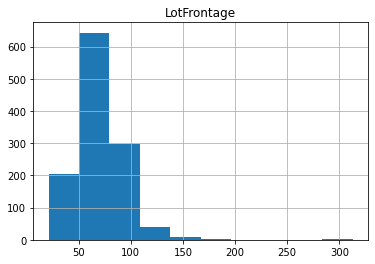

In [14]:
X_numeric.hist(column = 'LotFrontage')

#### GarageYrBlt

From the data descrption document: 'Year garage was built'

These values could be missing either because the information wasn't recorded or, more likely, there is no garage. However, having the value '0' to represent no garage would not make sense in this scenario because the other values are dates, and zero values in this case would not work well with regression. 

We have the option to either drop this column, or to fill it with the median (as the data is not normally distributed).

The benefit of imputing the missing information rather than dropping the column is we retain all the information within the column. The risk is that if we are imputing a year built for a garage (that never existed), this may create noise in the model which makes it less effective. 

We can investigate which of these two approaches, imputation or exclusion, gives the lowest RSME later. 

In [15]:
print(X_numeric['GarageYrBlt'].median())
print(X_numeric['GarageYrBlt'].mean())

#Checking minimum to ensure no values are '0' and can skew results
print(X_numeric['GarageYrBlt'].min())

1980.0
1978.5061638868744
1900.0


array([[<AxesSubplot:title={'center':'GarageYrBlt'}>]], dtype=object)

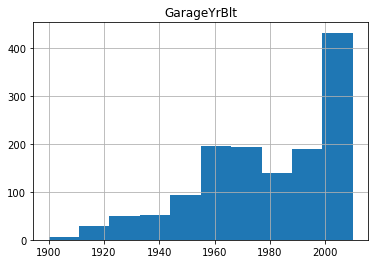

In [16]:
X_numeric.hist(column = 'GarageYrBlt')

#### MasVnrArea

From the data descrption document: 'Masonry veneer area in square feet'



In [17]:
print(X_numeric['MasVnrArea'].median())
print(X_numeric['MasVnrArea'].mean())
print(X_numeric['MasVnrArea'].min())

0.0
103.68526170798899
0.0


array([[<AxesSubplot:title={'center':'MasVnrArea'}>]], dtype=object)

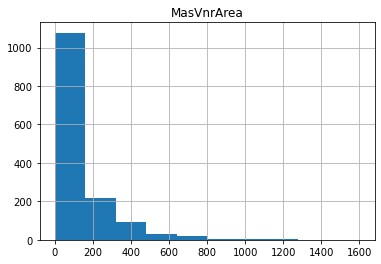

In [18]:
X_numeric.hist(column = 'MasVnrArea')

Investigating the data, we see both the minimum value and median are 0, which means these missing values were likely not collected, rather than indicating an absence of any masonry veneer. We can impute with median as the masonry veneer area data is not normally distributed (we can see this in both the large difference between mean and median and the histogram).

In summary, we can use a median imputation strategy for all the numerical columns with missing data.

#### Testing best handling method for GarageYrBuilt

First we'll impute all the missing numerical data and calculate the RMSE:

In [19]:
imputer = SimpleImputer(strategy='median')

imputed_X_numeric = pd.DataFrame(imputer.fit_transform(X_numeric))

imputed_X_numeric.columns = X_numeric.columns

RMSE_score(imputed_X_numeric)

Average RMSE score: 29780.558322489484


Next we'll see if dropping the GarageYrBlt column entirely improves the RMSE score:

In [20]:
imputed_X_numeric_2 = imputed_X_numeric.drop('GarageYrBlt', axis=1)

RMSE_score(imputed_X_numeric_2)

Average RMSE score: 30075.872556619765


As we can see, dropping this column did not help lower the RSME score. Therefore our strategy will be to impute missing data in GarageYrBlt rather than to exclude the column.

## Categorical missing data

In [21]:
# Create X with only categorical columns
X_object = train_data[object_cols].copy()

# Get categorical columns with missing data in the train data
missing_objdata_count_by_column = X_object[object_cols].isnull().sum()
print(missing_objdata_count_by_column[missing_objdata_count_by_column > 0].sort_values(ascending=False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrType         8
Electrical         1
dtype: int64


Let's check if there is missing data in the test data, and if there is, that it is from the same columns as the train data:

In [22]:
# Get categorical columns with missing data in the test data
missing_objtestdata_count_by_column = test_data[object_cols].isnull().sum()
print(missing_objtestdata_count_by_column[missing_objtestdata_count_by_column > 0].sort_values(ascending=False))

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MSZoning           4
Functional         2
Utilities          2
KitchenQual        1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64


To make the missing data easier to handle as there's a lot of it in the object columns, let's combine the two lists of missing data into a single dataframe:

In [23]:
#Concatenate the datasets
all_missing_obj_data = pd.concat([missing_objdata_count_by_column,missing_objtestdata_count_by_column],axis=1)

#Rename columns
all_missing_obj_data = all_missing_obj_data.rename(columns = {0:'Train data',1:'Test data'})

#Create a count of total number of missing data across both the train and test datasets
all_missing_obj_data['Total'] = all_missing_obj_data['Train data'] + all_missing_obj_data['Test data']

#Display all missing categorical data, starting with columns with the most total missing data
all_missing_obj_data.loc[all_missing_obj_data['Total']>0].sort_values('Total', ascending=False)

,Train data,Test data,Total
PoolQC,1453,1456,2909
MiscFeature,1406,1408,2814
Alley,1369,1352,2721
Fence,1179,1169,2348
FireplaceQu,690,730,1420
GarageQual,81,78,159
GarageFinish,81,78,159
GarageCond,81,78,159
GarageType,81,76,157
BsmtCond,37,45,82


Let's start with the columns with a high proportion of missing data, as there are likely to be good reasons why there is so much missing data. 

Looking at the data descriptions for these columns, we can see that **missing data represents missing features**: 

#### PoolQC
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

This column has ordinal columns with a clear ranking, so we can use ordinal encoding with NA or None representing No Pool. We will have to impute all 'nan' values.

#### MiscFeature
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

This column can be one-hot coded.

#### Alley
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

This column can be one-hot coded. 

#### Fence
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

While Good Privacy can be ranked with Minimum Privacy and No Fence (and equally Good Wood with Minimum Wood/Wire and No Fence), privacy and fence material are more difficult to rank (possibly these should have been two separate columns as privacy and wood type are not mutually exclusive), so one-hot encoding would be a safer bet for this column.

#### FireplaceQu
FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
       
There is a clear ranking in these categories, so we can use ordinal encoding for this column. We will need to impute the 'nan's so make them into variables which can be encoded.

### Garage data

There are four columns containing garage data which have missing data. The 'missing' data appears to represent no garage, so we will need to impute the 'nan' values with a variable to represent no garage.

    
#### GarageQual

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### GarageFinish

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### GarageCond

GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### GarageType

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

There is no clear ranking in these categories, so we need to one-hot encode this column.

### Basement

There are five columns containing basement data which have missing data. Where this data is missing, it appears to represent no basement, and we will need to impute the 'nan' values with a variable to represent no basement area.

#### BsmtQual

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### BsmtCond

BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### BsmtExposure

BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### BsmtFinType1

BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### BsmtFinType2

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

There is a clear ranking in these categories, so we can use ordinal encoding for this column.

There are eight remaining columns with missing data - due to the small number of missing data, these are much likely to be cases where the data was not collected, rather than an abscence of something (like a garage or basement).

#### MasVnrType

MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

Here we see that the label for none is 'None', rather than 'NA' as in the case of 'No Garage', 'No Basement', etc. We can see below that homes with no masonry veneer were recorded as 'None'. The missing data was simply not recorded. We can impute the missing data with most frequent value. This column will need to be one-hot encoded.   

In [67]:
X_object['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

#### MSZoning

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
       
Missing vales can be imputed with most frequent value. This column will be one-hot encoded.

#### Utilities

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
       
Missing vales can be imputed with most frequent value. There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### Electrical

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

Missing vales can be imputed with most frequent value. There is no clear ranking in these categories, so we will one-hot encode this column.

#### KitchenQual

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

Missing vales can be imputed with most frequent value. There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### Functional

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

Missing vales can be imputed with most frequent value. There is a clear ranking in these categories, so we can use ordinal encoding for this column.

#### SaleType

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

Missing vales can be imputed with most frequent value. There is no clear ranking in these categories, so we will one-hot encode this column.

### Exteriors

#### Exterior1st

Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
#### Exterior2nd

Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
       
Missing vales can be imputed with most frequent value. These columns will be one-hot encoded.

# Preprocessing categorical data

Next we'll look at all the categorical columns that did not have missing data to decide if they can be ordinal encoded, or should be one-hot encoded.

When working with large datasets, the cardinality (number of unique values in a column) of columns to be one-hot encoded would be considered. Columns with high cardinality would likely be dropped instead of one-hot encoded as they add significantly to processing time. However, the dataset we have is relatively small so we'll one-hot columns with even high cardinality as to get the most accurate model possible.

In [41]:
# Get all categorical columns that didn't have missing data

all_missing_obj_data.loc[all_missing_obj_data['Total']==0].sort_values('Total', ascending=False)

,Train data,Test data,Total
Street,0,0,0
LotShape,0,0,0
PavedDrive,0,0,0
CentralAir,0,0,0
HeatingQC,0,0,0
Heating,0,0,0
Foundation,0,0,0
ExterCond,0,0,0
ExterQual,0,0,0
RoofMatl,0,0,0


### Encoding type

Street: Type of road access to property - ONE-HOT ENCODING

       Grvl	Gravel	
       Pave	Paved
       
LotShape: General shape of property - ORDINAL ENCODING

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular


PavedDrive: Paved driveway - ORDINAL ENCODING

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

CentralAir: Central air conditioning - ORDINAL ENCODING

       N	No
       Y	Yes

HeatingQC: Heating quality and condition - ORDINAL ENCODING

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

Heating: Type of heating - ONE-HOT ENCODING
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

Foundation: Type of foundation - ONE-HOT ENCODING
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

ExterQual: Evaluates the quality of the material on the exterior - ORDINAL ENCODING
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior - ORDINAL ENCODING
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

RoofStyle: Type of roof - ONE-HOT ENCODING

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		
RoofMatl: Roof material - ONE-HOT ENCODING

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
       
BldgType: Type of dwelling - ONE-HOT ENCODING
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
HouseStyle: Style of dwelling - ONE-HOT ENCODING
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

Condition1: Proximity to various conditions - ONE-HOT ENCODING
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition2: Proximity to various conditions (if more than one is present) - ONE-HOT ENCODING
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

LotConfig: Lot configuration - ONE-HOT ENCODING

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
	
LandSlope: Slope of property - ORDINAL ENCODING
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
	
Neighborhood: Physical locations within Ames city limits - ONE-HOT ENCODING (note: in large datasets, because of the large cardinality of this column, feature engineering could be used to replace the need for one-hot encoding, for example by replacing with average cost of homes in the neighbourhood (although this risks target leakage if the SalesPrice from the train data itself is used), or distance to city centre)

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

LandContour: Flatness of the property - ORDINAL ENCODING

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
       
SaleCondition: Condition of sale - ONE HOT ENCODING

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

After investigating all the categorical columns, we can split them into the following categories:

**Encoding treatment:**
- *Columns to be ordinal encoded (ordinal):* LotShape, PavedDrive, CentralAir, HeatingQC, ExterQual, ExterCond, LandSlope, LandContour, PoolQC, FireplaceQu, GarageQual, GarageFinish, GarageCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2,  Utilities,  KitchenQual,  Functional
- *Columns to be one-hot encoded (nominal):* Street, Heating, Foundation, RoofStyle, RoofMatl, BldgType, HouseStyle, Condition1, Condition2, LotConfig, Neighborhood, SaleType, MiscFeature, Alley, Fence, GarageType, MasVnrType,  MSZoning,  SaleType, Exterior1st, Exterior2nd, Electrical

**Imputation treatment:**
- *Columns to be imputed with missing values as 'NA' or 'None':* PoolQC, FireplaceQu, GarageQual, GarageFinish, GarageCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, SaleCondition, MiscFeature, Alley, Fence, GarageType
- *Columns to be imputed with a most frequent value:* MasVnrType,  Utilities, KitchenQual,  Functional, MSZoning, Sale Type, Exterior1st, Exterior2nd, Electrical

In [42]:
# Define columns to be imputed with a constant ('NA')
ordinal_NA_cols = ['LotShape', 'PavedDrive', 'CentralAir', 'HeatingQC', 'ExterQual', 'ExterCond', 'LandSlope', 'LandContour', 'PoolQC', 'FireplaceQu', 'GarageQual', 'GarageFinish', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
nominal_NA_cols = ['Street', 'Heating', 'Foundation', 'RoofStyle', 'RoofMatl', 'BldgType', 'HouseStyle', 'Condition1', 'Condition2', 'LotConfig', 'Neighborhood', 'SaleCondition', 'MiscFeature', 'Alley', 'Fence', 'GarageType']

In [43]:
# Define columns to be imputed with the most frequent value
ordinal_MF_cols = ['Utilities', 'KitchenQual',  'Functional']
nominal_MF_cols = ['MasVnrType', 'MSZoning', 'SaleType', 'Exterior1st', 'Exterior2nd', 'Electrical']

# Basic feature engineering

As this is a tree model, two types of features which might boost performance are ratio combinations and counts.

All the columns we will be using to create the features are numerical. Previously it was decided to impute all missing data in numerical columns using a median strategy. We will impute numerical columns before creating features so features are not affected by missing data.

In [44]:
numeric_imputer = SimpleImputer(strategy='median')

# Impute missing data in numerical columns
fnum_X_train = pd.DataFrame(numeric_imputer.fit_transform(X_train[numeric_cols]))
fnum_X_test = pd.DataFrame(numeric_imputer.transform(test_data[numeric_cols]))

# Put column names back as they are removed during imputation
fnum_X_train.columns = X_train[numeric_cols].columns
fnum_X_test.columns = test_data[numeric_cols].columns

In [45]:
# Create dataframes to hold new features
X_train_feat = pd.DataFrame()  
X_test_feat = pd.DataFrame() 

#### Outdoor area features  

We are able to utilise the below columns to make new features about outdoor living areas:
- WoodDeckSF: Wood deck area in square feet  
- OpenPorchSF: Open porch area in square feet  
- EnclosedPorch: Enclosed porch area in square feet  
- 3SsnPorch: Three season porch area in square feet  
- ScreenPorch: Screen porch area in square feet  

In [46]:
fnum_X_train['ThreeSsnPorch'] = fnum_X_train['3SsnPorch']
fnum_X_test['ThreeSsnPorch'] = fnum_X_test['3SsnPorch']

In [47]:
# Calculate total area of outdoor living space

X_train_feat['OutdoorLivingSF'] = fnum_X_train.WoodDeckSF + fnum_X_train.OpenPorchSF + fnum_X_train.EnclosedPorch  + fnum_X_train.ScreenPorch + fnum_X_train.ThreeSsnPorch
X_test_feat['OutdoorLivingSF'] = fnum_X_test.WoodDeckSF + fnum_X_test.OpenPorchSF + fnum_X_test.EnclosedPorch  + fnum_X_test.ScreenPorch + fnum_X_test.ThreeSsnPorch

In [48]:
# Calculate ratio of outdoor living space to indoor living space

X_train_feat['IndoorOutdoorLivRto'] =  X_train_feat.OutdoorLivingSF /fnum_X_train.GrLivArea
X_test_feat['IndoorOutdoorLivRto'] = X_test_feat.OutdoorLivingSF /fnum_X_test.GrLivArea

In [49]:
# Count the number of different types of outdoor living areas

outdoor_areas = [ 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'ThreeSsnPorch']

X_train_feat['TypesOutdoorLvgAreas'] = fnum_X_train[outdoor_areas].gt(0).sum(axis=1)
X_test_feat['TypesOutdoorLvgAreas'] = fnum_X_test[outdoor_areas].gt(0).sum(axis=1)

#### Bathroom features

Currently bathrooms are split across four different columns, whereas prospective buyers are usually interested in total bathrooms:
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade

In [50]:
# Create bathroom totals
X_train_feat['TotalFullBath'] =  fnum_X_train.FullBath + fnum_X_train.BsmtFullBath
X_test_feat['TotalFullBath'] = fnum_X_test.FullBath + fnum_X_test.BsmtFullBath

X_train_feat['TotalHalfBath'] =  fnum_X_train.FullBath + fnum_X_train.BsmtHalfBath
X_test_feat['TotalHalfBath'] = fnum_X_test.FullBath + fnum_X_test.BsmtHalfBath

X_train_feat['TotalBath'] =  X_train_feat.TotalFullBath + X_train_feat.TotalHalfBath
X_test_feat['TotalBath'] = X_test_feat.TotalFullBath + X_test_feat.TotalHalfBath

#### House and lot size and quality Features

We will be using the following columns to make features:
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- LotArea: Lot size in square feet

In [51]:
fnum_X_train['FirstFlrSF'] = fnum_X_train['1stFlrSF']
fnum_X_test['FirstFlrSF'] = fnum_X_test['1stFlrSF']

fnum_X_train['SndFlrSF'] = fnum_X_train['2ndFlrSF']
fnum_X_test['SndFlrSF'] = fnum_X_test['2ndFlrSF']

In [52]:
# Total space above ground
X_train_feat['TtlSFAbvGrd'] =  fnum_X_train.FirstFlrSF + fnum_X_train.SndFlrSF
X_test_feat['TtlSFAbvGrd'] = fnum_X_test.FirstFlrSF + fnum_X_test.SndFlrSF

# Total SF in the house
X_train_feat['TtlSF'] =  fnum_X_train.FirstFlrSF + fnum_X_train.SndFlrSF + fnum_X_train.TotalBsmtSF
X_test_feat['TtlSF'] = fnum_X_test.FirstFlrSF + fnum_X_test.SndFlrSF + fnum_X_test.TotalBsmtSF

# Size of rooms (above ground)
X_train_feat['RoomSizeAbvGrd'] = X_train_feat.TtlSFAbvGrd / fnum_X_train.TotRmsAbvGrd 
X_test_feat['RoomSizeAbvGrd'] = X_test_feat.TtlSFAbvGrd / fnum_X_test.TotRmsAbvGrd 

# Ratio of property with low quality finish
X_train_feat['LowQualRto'] = fnum_X_train.LowQualFinSF / X_train_feat.TtlSF
X_test_feat['LowQualRto'] = fnum_X_test.LowQualFinSF / X_test_feat.TtlSF 

In [53]:
# Lot size minus house 1st floor SF (house footprint) to determine land/garden size
X_train_feat['LandSize'] =  fnum_X_train.LotArea - fnum_X_train.FirstFlrSF
X_test_feat['LandSize'] = fnum_X_test.LotArea - fnum_X_test.FirstFlrSF

# Ratio of living area to lot size
X_train_feat['LivLotRto'] =  fnum_X_train.GrLivArea / fnum_X_train.LotArea
X_test_feat['LivLotRto'] = fnum_X_test.GrLivArea / fnum_X_test.LotArea

In [54]:
# Create an X_train with added features for model tuning

Xf_train = pd.concat([X_train, X_train_feat], axis=1)

In [55]:
# Define feature columns
feat_cols = ['OutdoorLivingSF', 'IndoorOutdoorLivRto', 'TypesOutdoorLvgAreas', 'TotalFullBath', 'TotalHalfBath', 'TotalBath', 'TtlSFAbvGrd', 'TtlSF', 'RoomSizeAbvGrd', 'LowQualRto', 'LandSize', 'LivLotRto']

# Testing for category discrepancies between the train and test data

There may be datasets where categorical columns in the test data contain categories not seen in the train data. If such a situation occurs, how it is best dealt with may vary based on the number of categories not seen in the train data (e.g. large number of categories not seen in train may mean we consider dropping the column entirely). 

In [68]:
# Test every categotical column
for col in object_cols:
    # Get unique entries (categories) for both train and test data
    train_cats = train_data[col].unique()
    test_cats = test_data[col].unique()
    
    # Create empty list
    cats_not_seen = []
    
    # For every unique category in the test dataset, check that it also appears in the train data
    for cat in test_cats:
        if cat not in train_cats:
            # If not seen in the train data, add to list
            cats_not_seen.append(cat)
            
    if len(cats_not_seen) > 0:
        # Print column and corresponding list of categories in test not seen in train
        print(col, " : ", cats_not_seen)

MSZoning  :  [nan]
Alley  :  [nan]
Utilities  :  [nan]
Exterior1st  :  [nan]
Exterior2nd  :  [nan]
MasVnrType  :  [nan]
BsmtQual  :  [nan]
BsmtCond  :  [nan]
BsmtExposure  :  [nan]
BsmtFinType1  :  [nan]
BsmtFinType2  :  [nan]
KitchenQual  :  [nan]
Functional  :  [nan]
FireplaceQu  :  [nan]
GarageType  :  [nan]
GarageFinish  :  [nan]
GarageQual  :  [nan]
GarageCond  :  [nan]
PoolQC  :  [nan]
Fence  :  [nan]
MiscFeature  :  [nan]
SaleType  :  [nan]


We can see here only missing data is represented - this will be imputed so there are no columns with categories in test that were not seen in train.

# Creating a pipeline

When creating a pipeline, we'll first define the preprocessing required for each 'set' of data we have defined. We will then bundle preprocessing together with the model.

Although there are no categorical columns in the test data containing categories that do not exist in the train data, when we wish to test our train data, it will be split into train and valid sets, and in these situations it is likely there may be categories in the valid data not seen in the train data. Therefore we need to put handle_unknown clauses into our encoders to stop errors from being thrown. Note that v24 of scikit-learn is needed to use the parameters handle_unknown and unknown_value for OrdinalEncoder.

In [55]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for ordinal categorical data needing constant imputation
ordinal_NA_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Preprocessing for nominal categorical data needing constant imputation
nominal_NA_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Preprocessing for ordinal categorical data needing most frequent imputation
ordinal_MF_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Preprocessing for nominal categorical data needing most frequent imputation
nominal_MF_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [56]:
# Bundle the various types of preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('nomNA', nominal_NA_transformer, nominal_NA_cols),
        ('ordNA', ordinal_NA_transformer, ordinal_NA_cols),
        ('nomMF', nominal_MF_transformer, nominal_MF_cols),
        ('ordMF', ordinal_MF_transformer, ordinal_MF_cols),
        ('feat', numerical_transformer, feat_cols)
        
    ])

# Define model
model = XGBRegressor(random_state=0, n_estimators=1000, learning_rate=0.05)

In [57]:
# Bundle preprocessing and model code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [58]:
# Calculate RMSE
scores = -1 * cross_val_score(my_pipeline, Xf_train, y,
                              cv=5,
                              scoring='neg_root_mean_squared_error')

print("Average RMSE score:", scores.mean())

Average RMSE score: 27218.751378608653


# Model parameter tuning

To tune our model, we will be using two techniques: XGBoost's early stopping rounds function, and hyperparameter tuning using RandomizedSearchCV. 

As the data will not be processed in the pipeline, we'll need to process it before hand. 

For early stopping rounds we will need both a training and validation dataset. For RandomizedSearchCV, we can use the full training dataset as it uses cross validation. Therefore, before tuning, we will preprocess both the full training data, and the train data split into 'train' and 'valid' subsets.

In [59]:
# Define imputers and encoders. We will use pandas get_dummies for one-hot encoding
t_numeric_imputer = SimpleImputer(strategy='median')
t_NA_imputer = SimpleImputer(strategy='constant', fill_value='NA')
t_MF_imputer = SimpleImputer(strategy='most_frequent')
t_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [60]:
# Split the train data into training and validation subsets

t_X_train, t_X_valid, t_y_train, t_y_valid = train_test_split(Xf_train, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [61]:
# Impute missing data in numerical columns
num_t_X_train = pd.DataFrame(t_numeric_imputer.fit_transform(t_X_train[numeric_cols]))
num_t_X_valid = pd.DataFrame(t_numeric_imputer.transform(t_X_valid[numeric_cols]))

# Put column names back as they are removed during imputation
num_t_X_train.columns = t_X_train[numeric_cols].columns
num_t_X_valid.columns = t_X_valid[numeric_cols].columns

# Same processing for complete training data
num_t_X_fulltrain = pd.DataFrame(t_numeric_imputer.fit_transform(X_train[numeric_cols]))
num_t_X_fulltrain.columns = X_train[numeric_cols].columns

In [62]:
# Process feature data
feat_t_X_train = pd.DataFrame(t_numeric_imputer.fit_transform(t_X_train[feat_cols]))
feat_t_X_valid = pd.DataFrame(t_numeric_imputer.transform(t_X_valid[feat_cols]))

# Put column names back
feat_t_X_train.columns = t_X_train[feat_cols].columns
feat_t_X_valid.columns = t_X_valid[feat_cols].columns

In [63]:
# Define categorical columns to be imputed using constant and most frequent strategies
cols_impute_NA = nominal_NA_cols + ordinal_NA_cols
cols_impute_MF = nominal_MF_cols + ordinal_MF_cols

In [64]:
# Impute categorical columns

# Impute missing data in categorical columns with 'NA' constant
NA_t_X_train = pd.DataFrame(t_NA_imputer.fit_transform(t_X_train[cols_impute_NA]))
NA_t_X_valid = pd.DataFrame(t_NA_imputer.transform(t_X_valid[cols_impute_NA]))

# Put column names back as they are removed during imputation
NA_t_X_train.columns = t_X_train[cols_impute_NA].columns
NA_t_X_valid.columns = t_X_valid[cols_impute_NA].columns

# Impute missing data in categorical columns with most frequent values
MF_t_X_train = pd.DataFrame(t_MF_imputer.fit_transform(t_X_train[cols_impute_MF]))
MF_t_X_valid = pd.DataFrame(t_MF_imputer.transform(t_X_valid[cols_impute_MF]))

# Put column names back as they are removed during imputation
MF_t_X_train.columns = t_X_train[cols_impute_MF].columns
MF_t_X_valid.columns = t_X_valid[cols_impute_MF].columns

# Same processing for complete training data
NA_t_X_fulltrain = pd.DataFrame(t_NA_imputer.fit_transform(X_train[cols_impute_NA]))
NA_t_X_fulltrain.columns = X_train[cols_impute_NA].columns

MF_t_X_fulltrain = pd.DataFrame(t_MF_imputer.fit_transform(X_train[cols_impute_MF]))
MF_t_X_fulltrain.columns = X_train[cols_impute_MF].columns

In [65]:
# Put categorical column datasets back together for encoding
cat_t_X_train = pd.concat([NA_t_X_train, MF_t_X_train], axis=1)
cat_t_X_valid = pd.concat([NA_t_X_valid, MF_t_X_valid], axis=1)

# Same treatment for complete training data
cat_t_X_fulltrain = pd.concat([NA_t_X_fulltrain, MF_t_X_fulltrain], axis=1)

In [66]:
# Define categorical columns to be ordinal encoded and one-hot encoded
cols_onehot = nominal_NA_cols + nominal_MF_cols
cols_ordinal = ordinal_NA_cols + ordinal_MF_cols

In [67]:
# Using pandas get_dummies to one-hot encode categorical columns
OH_t_X_train = pd.get_dummies(cat_t_X_train[cols_onehot])
OH_t_X_valid = pd.get_dummies(cat_t_X_valid[cols_onehot])

# Same processing for complete training data
OH_t_X_fulltrain = pd.get_dummies(cat_t_X_fulltrain[cols_onehot])

In [68]:
# Impute missing data in categorical columns with most frequent values
ord_t_X_train = pd.DataFrame(t_ordinal_encoder.fit_transform(cat_t_X_train[cols_ordinal]))
ord_t_X_valid = pd.DataFrame(t_ordinal_encoder.transform(cat_t_X_valid[cols_ordinal]))

# Put column names back as they are removed during encoding
ord_t_X_train.columns = cat_t_X_train[cols_ordinal].columns
ord_t_X_valid.columns = cat_t_X_valid[cols_ordinal].columns

# Same processing for complete training data
ord_t_X_fulltrain = pd.DataFrame(t_ordinal_encoder.fit_transform(cat_t_X_fulltrain[cols_ordinal]))
ord_t_X_fulltrain.columns = cat_t_X_fulltrain[cols_ordinal].columns

In [69]:
# Put processed numeric, one-hot encoded, ordinal encoded and feature columns back together
pt_X_train = pd.concat([num_t_X_train, OH_t_X_train, ord_t_X_train, feat_t_X_train], axis=1)
pt_X_valid = pd.concat([num_t_X_valid, OH_t_X_valid, ord_t_X_valid, feat_t_X_valid], axis=1)

pt_X_fulltrain = pd.concat([num_t_X_fulltrain, OH_t_X_fulltrain, ord_t_X_fulltrain, X_train_feat], axis=1)

The first time the model was fit, there were two errors: 
- expected Electrical_Mix, Heating_Floor, SaleType_ConLw, RoofMatl_Membran, Condition2_PosA, Neighborhood_Blueste, Exterior2nd_CBlock, MiscFeature_Gar2, Exterior1st_ImStucc, Exterior1st_Stone, Condition1_RRNe, RoofMatl_Roll, Exterior1st_CBlock, Heating_OthW, RoofMatl_WdShake, Exterior1st_AsphShn, GarageType_2Types, RoofStyle_Shed, MiscFeature_Othr, RoofMatl_Metal, Exterior2nd_Other, Condition2_RRAe, Heating_Grav, Foundation_Stone in input data
- training data did not have the following fields: MiscFeature_TenC, RoofMatl_ClyTile, Condition2_RRNn, Condition2_RRAn

This is where there nominal categorical columns, which we one-hot encode, have different sets of unique categories in the training and validation data, meaning different columns will be created during one-hot encoding. In the pipeline, these discrepancies are handled using handle_unknown parameters, however in this case we will simply drop these columns.

In [70]:
# Create final X_train and X_valid for tuning use
ft_X_train = pt_X_train.drop(['Electrical_Mix', 'Heating_Floor', 'SaleType_ConLw', 'RoofMatl_Membran', 'Condition2_PosA', 'Neighborhood_Blueste', 'Exterior2nd_CBlock', 'MiscFeature_Gar2', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Condition1_RRNe', 'RoofMatl_Roll', 'Exterior1st_CBlock', 'Heating_OthW', 'RoofMatl_WdShake', 'Exterior1st_AsphShn', 'GarageType_2Types', 'RoofStyle_Shed', 'MiscFeature_Othr', 'RoofMatl_Metal', 'Exterior2nd_Other', 'Condition2_RRAe', 'Heating_Grav', 'Foundation_Stone'], axis=1)
ft_X_valid = pt_X_valid.drop(['MiscFeature_TenC', 'RoofMatl_ClyTile', 'Condition2_RRNn', 'Condition2_RRAn'], axis=1)

### Tuning using early stopping rounds

Using the XGBoost's early stopping rounds feature, we can investigate which learning rates produce the lowest RMSE, as well as the optimal number of estimators for each learning rate.

In [71]:
# Define model
tuning_model_1 = XGBRegressor(random_state=0, n_estimators=1500, learning_rate=0.03)

In [ ]:
# Fit model with early stopping rounds to get (a) best number of estimators and (b) the RMSE
# (Cleared output as early stopping rounds creates hundreds of lines)

tuning_model_1.fit(ft_X_train, t_y_train, 
             early_stopping_rounds=50, 
             eval_set=[(ft_X_valid, t_y_valid)],
             verbose=True)

The following learning rates generate the following RMSE scores:
- 0.1: RMSE ~30400
- 0.07: RMSE ~31300
- 0.05: RMSE ~28600
- 0.03: RMSE ~29500

As we can see, the lower learning rates had the lowest RMSE scores. A small learning rate and large number of estimators will generally create a more accurate XGBoost model.

### Hyperparameter tuning

In addition to tuning parameters using early stopping rounds, which was taught in Kaggle's Intermediate Machine Learning course, I decided to try hyperparameter tuning using RandomizedSearchCV to generate an even more effective model.

In [73]:
# Define model
tuning_model = XGBRegressor(random_state=0)

In [74]:
# Defining parameters to tune

tuning_parameters = {
    'n_estimators' : [300, 500, 700, 900, 1100, 1300],
    'learning_rate': [0.3, 0.5],
    'min_child_weight' : [1, 3, 5, 7],
    'max_depth' : [3, 4, 5, 6, 7],
}

In [75]:
# Define random search - five folds, using RMSE as evaluation

random_search = RandomizedSearchCV(tuning_model, param_distributions=tuning_parameters, n_iter=10, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)

In [76]:
# Fit using full training data

random_search.fit(pt_X_fulltrain, y)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          num_parallel_tree=None,
                                          random_state=0, reg_alpha=None,
                                          reg_lamb

In [77]:
# Get best parameters of those tried by the random search

random_search.best_params_

{'n_estimators': 1100,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.3}

After running random search several times, a pattern emerged in the best parameters:  
- {'n_estimators': 1300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.3}  
- {'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.3}  
- {'n_estimators': 900, 'min_child_weight': 3,'max_depth': 4, 'learning_rate': 0.3}  

A learning rate of 0.03, min child weight of 3 and max depth of 4 seem to be optimal. The number of estimators varied, so I ran the model with different n_estimators to investigate which gave the lowest RMSE:

In [78]:
tuning_model_est = XGBRegressor(random_state=0, n_estimators=1200, learning_rate=0.03, min_child_weight=3, max_depth=4)

scores = -1 * cross_val_score(tuning_model_est, pt_X_fulltrain, y,
                                cv=5,
                                scoring='neg_root_mean_squared_error')

print("Average RMSE score:", scores.mean())

Average RMSE score: 25754.36687703566


Using the number of estimators given by the search's best parameters:
- RMSE with n_estimators=500: 25921  
- RMSE with n_estimators=900: 25674  
- RMSE with n_estimators=1300: 25636  

As the RMSE for n_est=900 and n_est=1300 was very similar, I suspected the optimal point was somewhere inbetween them:  
- RMSE with n_estimators=1000: 25655  
- RMSE with n_estimators=1100: 25632  
- RMSE with n_estimators=1200: 25636  

The optimal number of estimators is 1100, so now we can fit our model with these parameters.

## Fitting the model

In [79]:
# Define final model
final_model = XGBRegressor(random_state=0, n_estimators=1100, learning_rate=0.03, max_depth=4, min_child_weight=3)

# Create final pipeline
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', final_model)
                             ])

In [80]:
# Combine the train and test data with features we have created

final_X_train = pd.concat([train_data[numeric_cols + nominal_NA_cols + ordinal_NA_cols + nominal_MF_cols + ordinal_MF_cols], X_train_feat], axis=1)
final_X_test = pd.concat([test_data[numeric_cols + nominal_NA_cols + ordinal_NA_cols + nominal_MF_cols + ordinal_MF_cols], X_test_feat], axis=1)

In [81]:
# Fit the model
final_pipeline.fit(final_X_train, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'Ful...
                              colsample_bytree=1

## Making Predictions

In [82]:
# Create predictions and output them to CSV for submission

test_preds = final_pipeline.predict(final_X_test)

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

Final step: submit to kaggle for results!

My lowest RMSE upon submitting my test data predictions to kaggle was 13851, which ranked 1662 / 68950 for the competition.